# Identify Snowgum dieback  <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently only compatible with `DEA Sandbox` environment as near real time data is not available on the NCI
* **Products used:** 
[s2a_nrt_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_nrt_granule), 
[s2b_nrt_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_nrt_granule),
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule)

## Background

Dieback mapping


## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
import datacube
from datacube.utils import cog
from datetime import datetime
import pandas as pd
import geopandas as gpd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb, display_map
from dea_tools.dask import create_local_dask_cluster
from dea_tools.bandindices import calculate_indices
from dea_tools.plotting import map_shapefile


### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="SnowGum")

In [3]:
client = create_local_dask_cluster(return_client=True)

distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/JessWJ/dea-notebooks/Snowgum/dask-worker-space/worker-i32dpu8f', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/mickwelli@bigpond.com/proxy/8787/status,
Dashboard: /user/mickwelli@bigpond.com/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39741,Workers: 1
Dashboard: /user/mickwelli@bigpond.com/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:33313,Total threads: 2
Dashboard: /user/mickwelli@bigpond.com/proxy/36229/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:33797,


### Select location

The selected latitude and longitude will be displayed as a red box on the map below the next cell. 
This map can be used to find coordinates of other places, simply scroll and click on any point on the map to display the latitude and longitude of that location.

In [4]:
# Set the central latitude and longitude
central_lat = -36.394 
central_lon = 148.39

# Set the buffer to load around the central coordinates
buffer = 0.07

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

display_map(x=study_area_lon, y=study_area_lat, margin=-0.2)

In [5]:
area = gpd.read_file('Train_data/Plots_percent_affected.shp').to_crs("epsg:3577")
area

,Join_Count,TARGET_FID,JOIN_FID,Transect,plot,alti_bin50,trees_nota,trees_affe,total,percent_af,...,POINT_Y_av,FireName,FireNo,Label,StartDate,EndDate,AreaHa,PerimeterM,Verdate,geometry
0,0,0,-1,1,1,1750,11,1,12,0.083333,...,-4361127.791,None,None,None,None,None,0.0,0.0,None,POINT (1462307.143 -4075448.870)
1,0,1,-1,1,2,1750,21,0,21,0.000000,...,-4360708.980,None,None,None,None,None,0.0,0.0,None,POINT (1462491.221 -4075134.352)
2,0,2,-1,1,3,1800,19,2,21,0.095238,...,-4360795.740,None,None,None,None,None,0.0,0.0,None,POINT (1462451.706 -4075199.331)
3,0,3,-1,1,4,1800,24,0,24,0.000000,...,-4360894.899,None,None,None,None,None,0.0,0.0,None,POINT (1462408.486 -4075273.844)
4,0,4,-1,1,5,1800,10,5,15,0.333333,...,-4360987.472,None,None,None,None,None,0.0,0.0,None,POINT (1462369.996 -4075343.647)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0,98,-1,36,2,1750,2,9,11,0.818182,...,-4354526.942,None,None,None,None,None,0.0,0.0,None,POINT (1469719.659 -4071071.761)
99,0,99,-1,36,3,1800,0,7,7,1.000000,...,-4354535.841,None,None,None,None,None,0.0,0.0,None,POINT (1469649.091 -4071069.840)
100,0,100,-1,36,4,1850,11,3,14,0.214286,...,-4354562.084,None,None,None,None,None,0.0,0.0,None,POINT (1469570.220 -4071080.863)
101,0,101,-1,36,6,1850,8,10,18,0.555556,...,-4354592.568,None,None,None,None,None,0.0,0.0,None,POINT (1469409.785 -4071084.783)


In [6]:
map_shapefile(area, attribute = area.columns[0])

/home/jovyan/JessWJ/dea-notebooks/Snowgum/../Tools/dea_tools/plotting.py:418: FutureWarning: The `map_shapefile` function is deprecated, and will be removed from future versions of `dea-tools`. Please use Geopanda's built-in `.explore` functionality instead.
  warnings.warn("The `map_shapefile` function is deprecated, and will "


Label(value='')

Map(center=[-36.403951631203256, 148.37664686836447], controls=(ZoomControl(options=['position', 'zoom_in_text…

#### Define load parameters

In [7]:
time = ('2019-11', '2020-')
resolution = (-10, 10)
measurements = ['nbart_blue', 'nbart_green', 'nbart_red',
                'nbart_nir_1', 'nbart_nir_2', 'nbart_swir_2', 'nbart_swir_3']
min_gooddata = 0.5
output_crs = 'EPSG:3577'

## Load all baseline data

In [8]:
snowgum_ard = load_ard(dc=dc,
                       products=["s2a_ard_granule", "s2b_ard_granule"],
                       x=study_area_lon,
                       y=study_area_lat,
                       time=time,
                       measurements=measurements,
                       min_gooddata=min_gooddata,
                       output_crs=output_crs,
                       resolution=resolution,
                       group_by='solar_day',
                       dask_chunks = {"time": 1, "x": 3000, "y": 3000})

/home/jovyan/JessWJ/dea-notebooks/Snowgum/../Tools/dea_tools/datahandling.py:237: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Finding datasets
    s2a_ard_granule
    s2b_ard_granule
Counting good quality pixels for each time step
Filtering to 62 out of 166 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Returning 62 time steps as a dask array


## Generate indices

In [9]:
# Calculate NBR for the baseline images
snowgum_indices = calculate_indices(snowgum_ard, 
                             index=['NDVI', 'EVI', 'NBR'], 
                             collection='ga_s2_1', 
                             drop=False)

# Compute median using all observations in the dataset along the time axis
snowgum_median = snowgum_indices.median(dim='time')


Plot the baseline NBR data side-by-side with an RGB plot of the study area:

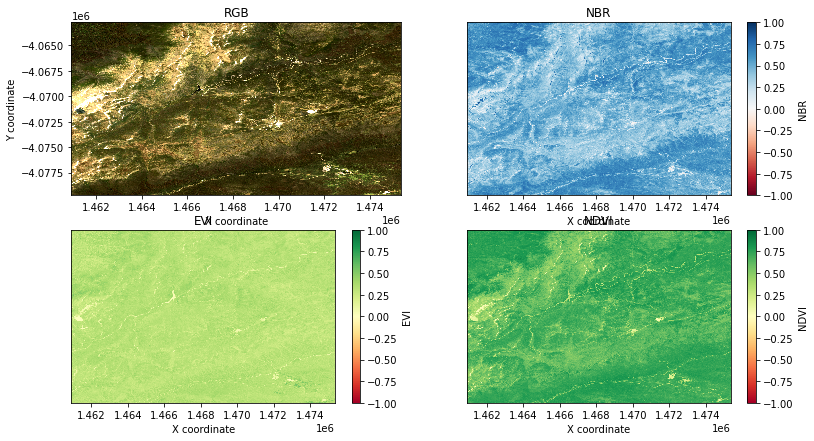

In [10]:
# Set up subplots
f, axarr = plt.subplots(2, 2, figsize=(13, 7), squeeze=False)

# Visualise baseline image as true colour image
rgb(snowgum_median, 
    bands=['nbart_red', 'nbart_green', 'nbart_blue'], 
    ax=axarr[0, 0])
axarr[0, 0].set_title('RGB')
axarr[0, 0].set_xlabel('X coordinate')
axarr[0, 0].set_ylabel('Y coordinate')

# Visualise baseline image as NBR image
snowgum_median.NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=axarr[0, 1])
axarr[0, 1].set_title('NBR')
axarr[0, 1].yaxis.set_visible(False)
axarr[0, 1].set_xlabel('X coordinate');

snowgum_median.EVI.plot(cmap='RdYlGn', vmin=-1, vmax=1, ax=axarr[1, 0])
axarr[1, 0].set_title('EVI')
axarr[1, 0].yaxis.set_visible(False)
axarr[1, 0].set_xlabel('X coordinate');

snowgum_median.NDVI.plot(cmap='RdYlGn', vmin=-1, vmax=1, ax=axarr[1, 1])
axarr[1, 1].set_title('NDVI')
axarr[1, 1].yaxis.set_visible(False)
axarr[1, 1].set_xlabel('X coordinate');

## Export results to GeoTIFF

The baseline reference image and the post fire image will both be saved as a multiband GeoTIFF with the following bands in the following order: Blue, Green, Red, NIR, SWIR. 

The thresholded burnt area image will be saved as a single band image, where a value of 1 = burnt and a value of 0 = not burnt.

In [11]:
# Define an area name to be used in saved file names
area_name = 'Snowgum'

# Write to multi-band GeoTIFF
cog.write_cog(snowgum_median.NDVI, f'{area_name}_NDVI.tif', overwrite=True).compute()
cog.write_cog(snowgum_median.NBR, f'{area_name}_NBR.tif', overwrite=True).compute()
cog.write_cog(snowgum_median.EVI, f'{area_name}_EVI.tif', overwrite=True).compute()

PosixPath('Snowgum_EVI.tif')

In [12]:
# Write all bands
cog.write_cog(snowgum_median.to_array(), f'{area_name}_bands_indices.tif', overwrite=True).compute()

PosixPath('Snowgum_bands_indices.tif')

In [13]:
snowgum_median

<xarray.Dataset>
Dimensions:       (y: 1701, x: 1447)
Coordinates:
  * y             (y) float64 -4.063e+06 -4.063e+06 ... -4.08e+06 -4.08e+06
  * x             (x) float64 1.461e+06 1.461e+06 ... 1.475e+06 1.475e+06
    spatial_ref   int32 3577
Data variables:
    nbart_blue    (y, x) float32 dask.array<chunksize=(567, 953), meta=np.ndarray>
    nbart_green   (y, x) float32 dask.array<chunksize=(567, 953), meta=np.ndarray>
    nbart_red     (y, x) float32 dask.array<chunksize=(567, 953), meta=np.ndarray>
    nbart_nir_1   (y, x) float32 dask.array<chunksize=(567, 953), meta=np.ndarray>
    nbart_nir_2   (y, x) float32 dask.array<chunksize=(567, 953), meta=np.ndarray>
    nbart_swir_2  (y, x) float32 dask.array<chunksize=(567, 953), meta=np.ndarray>
    nbart_swir_3  (y, x) float32 dask.array<chunksize=(567, 953), meta=np.ndarray>
    NDVI          (y, x) float32 dask.array<chunksize=(567, 953), meta=np.ndarray>
    EVI           (y, x) float32 dask.array<chunksize=(567, 953), meta=np.ndarray>
    NBR           (y, x) float32 dask.array<chunksize=(567, 953), meta=np.ndarray>

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2021

**Compatible datacube version:** 

In [14]:
print(datacube.__version__)

1.8.6


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)